# Evaluate commuter data over time
The code below takes labbeled data, trains a model with a growing amount of training.
Since this is done itaratively and compared to predictions towards a test set an estimation can be made over how fast the model converges.


In [32]:
#Setup
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai

#print(df)path="data"
dep_var = 'journey'
cat_names = ["detectedActivity","weekday"]
cont_names =["geoHash","minuteOfDay"]
procs = [FillMissing, Categorify, Normalize]

def predict_journeys(learner,dataset):  
    "Return"
    result = 0
    accuracy = 0
    for x in range(0,dataset.shape[0]):
        correct = dataset.iloc[x].journey  #remove journey
        predicted = learner.predict(dataset.iloc[x],pbar=None);
        if (correct==predicted[0]):
            result=result+1
    accuracy=result/dataset.shape[0]
    return(accuracy)
    
def predict_journey(detectedActivity,geoHash,minuteOfday,weekday):
    data = np.array([['','detectedActivity','geoHash','minuteOfDay','weekday'],
                ["row1",detectedActivity,geoHash,minuteOfday,weekday]])            
    dr=pd.DataFrame(data=data[1:,1:],
                    index=data[1:,0],
                    columns=data[0,1:]).astype(np.int64)
    predicted = learner.predict(dr.iloc[0])
    return(predicted[0],str(round(predicted[2].max().item(),2)))

def evaluate_learner(rows_per_training:int,filename,testfilename):
    dataSet = pd.read_csv("data/"+filename,comment="-")
    datasetTest = pd.read_csv("data/"+testfilename,comment="-")
    result = []
    size=dataSet.shape[0]
    for rows in range(rows_per_training,len(dataSet),rows_per_training):
        df=dataSet[0:rows]
        data = (TabularList.from_df(df, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(list(range(rows-(int(0.1*rows)), rows)))
                .label_from_df(cols=dep_var)
                .databunch())
        learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
        learner.fit_one_cycle(5)
        sizeR = len(learner.recorder.metrics)
        #run on testset
        resultTest = predict_journeys(learner,datasetTest)
        result.append([rows,learner.recorder.metrics[sizeR-1][0].item(),resultTest])
    return (result,size)

### Testing over the data set
Below we train models iteratively for each week (around 129 rows per week)
The resulting model is evaluated towards a test set that has the same distribution as the training set.
The result is ploted over time (no tweeking has been made for the individual weeks)
This assumes linear use for all weeks..


In [ ]:
%%capture
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12"#Andrea
user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
result,size = evaluate_learner(129,user+"_train_valid.csv",user+"_test.csv")

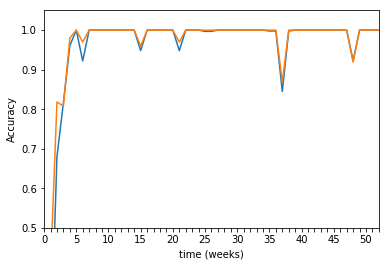

In [142]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
result = np.array(result)
##Assuming time for collection one year and linear use
rows_per_week = int(size/52)
fig, ax = plt.subplots()
ax.plot(result[:,0],result[:,1])
ax.plot(result[:,0],result[:,2])
plt.xlabel('time (weeks)')
plt.ylabel('Accuracy')
ax.axis([0,6000,0.5,1.05])
ax.set_xticks(np.arange(0, size, rows_per_week))
xs = range(0,size,5*rows_per_week)
def format_fn(tick_val, tick_pos):
    if int(tick_val) in xs:
        return int(tick_val/rows_per_week)
    else:
        return ''
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
plt.show()

## Building blocks and test code


Run test one cycle with part of the training set.

Total time: 00:03
epoch  train_loss  valid_loss  accuracy
1      1.027315    1.267255    0.780000  (00:00)
2      0.581179    0.295637    0.915000  (00:00)
3      0.339400    0.084656    0.990000  (00:00)
4      0.207102    0.046527    1.000000  (00:00)
5      0.152884    0.038357    1.000000  (00:00)



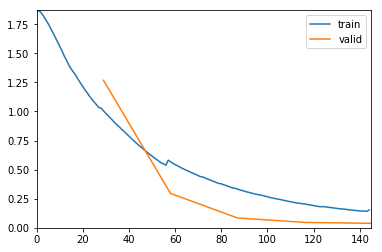

In [30]:
filename = "shuffeled.csv"
dataSetIn = pd.read_csv("data/"+filename,comment="-")
dataSet=dataSetIn[0:2000]
rows=dataSet.shape[0]
data = (TabularList.from_df(dataSet, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(list(range(rows-(int(0.1*rows)), rows)))
                .label_from_df(cols=dep_var)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
learner.fit_one_cycle(5)
#learn.fit(3, 1e-2)
#testSet = pd.read_csv("data/testWithLabels.csv",comment="-")
#resultTest = predict_journeys(learner,testSet)

Predict and view some rows

In [16]:
prediction,accuracy = predict_journey(3,1242479403,519,3)
print("Predicted journey from: "+str(prediction)[0:5]+" to " +str(prediction)[5:10]+ " with accuracy "+str(accuracy));
print(testSet[5:10])

Predicted journey from: 81216 to 80000 with accuracy 0.51
   detectedActivity     geoHash  minuteOfDay  weekday     journey
5                 3  1242213299          998        4  8000081216
6                 3  1242479403          519        3  8121680000
7                 7  1242479279          514        3  8121680000
8                 3  1242212679         1347        3  8014081216
9                 7  1242479403         1156        6  8121680140
